In [26]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")

# import modules for preprocessing
from sklearn import tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression, RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def root_mean_squared_error(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def bias(y, y_pred):
	return np.mean(y_pred - y)
def variance(y_pred):
	return np.mean([yi**2 for yi in y_pred]) - np.mean(y_pred)**2


# import module for object serialization
import pickle



# Feature Engineering Continued

## One-Hot Encoding/Dummy Variables

Creating dummy variables allow us to input categorical variables into the Machine Learning models, which require that all input data be numerical. Here, they are numerical, but take on discrete numerical values, so we consider them as categorical.  Dummy variables only take on the value of 0 or 1 for the absence or presence of some aspect of the category that is expected to effect the outcome. We did not create polynomial and interaction features for dummy variables since the values are only 0 and 1.

In [2]:
df = pd.read_csv('data/modeling.csv')

In [3]:
# Get index of the columns
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'sale_age', 'age', 'renovated',
       'basement', 'viewed'],
      dtype='object')

In [4]:
# Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = df[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode']]
dum_index = dum_feat.columns
# To prevent what they call the dummy variable trap (related to multicollinearity), drop one of the dummy variable, as well as  the original categorical variable used in creating the dummy variables
df_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['bdr', 'bth', 'flr', 'cnd', 'grd', 'zip'])
df_dum.head()

,bdr_1,bdr_2,bdr_3,bdr_4,bdr_5,bdr_6,bdr_7,bdr_8,bdr_9,bdr_10,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Polynomial and Interaction Features

Polynomial features are created by raising our exisitng features by some exponent, generally not greater than 3 or 4.  Adding polynomial features helps the regression models to recognize nonlinear patterns. For instance, age is related to price in more of a parabolic function due to the higher premium placed on brand new constructions vs. vintage or historic homes, which are on opposite ends of the age spectrum.

Interaction features, however, are represented by one variable or feature multipled by another feature. The idea here is that feature A's effect on C depend on the differing values of feature B.  Let's say C is plant growth, feature A is the amount of bacteria and feature B is the amount of sunlight.  In low amounts of sunlight, a high amount of bacteria in the soil creates tall plants, let's say, but in high amounts of sunlight, that same amount of bacteria creates short plants.  Only an interaction feature would be able to express that relationship.

In [5]:
# Grab columns for polynominal and interaction features from the original dataframe without dummy variables
poly_feat = df.drop(['price', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode'], axis=1)
y = df['price']
# Use PolynomialFeatures to create binomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_feat)
poly_columns = poly.get_feature_names(poly_feat.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
# Concatenating two dataframes together for input into linear regression model
X = pd.concat([df_poly, df_dum], axis=1)
X.head()

,sqft_living,sqft_lot,waterfront,sqft_above,lat,long,sqft_living15,sqft_lot15,sale_age,age,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,2070.0,8893.0,0.0,2070.0,47.4388,-122.162,2390.0,7700.0,28.0,28.0,...,0,0,0,0,0,0,0,0,0,0
1,2900.0,6730.0,0.0,1830.0,47.6784,-122.285,2370.0,6283.0,37.0,37.0,...,0,0,0,0,0,0,0,0,0,0
2,3770.0,10893.0,0.0,3770.0,47.5646,-122.129,3710.0,9685.0,17.0,17.0,...,0,0,0,0,0,0,0,0,0,0
3,4560.0,14608.0,0.0,4560.0,47.6995,-122.228,4050.0,14226.0,25.0,25.0,...,0,0,0,0,0,0,0,0,0,0
4,2550.0,5376.0,0.0,2550.0,47.6647,-122.083,2250.0,4050.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0


# Instantiating and Fitting a Supervised Learning Model 

There are several techniques we could use to prepare a linear regression model, including taking it to pen and paper to calculate means, standard deviations, correlations, and covariance.  Here we employ OLS method or ordinary least squares method.

R^2 or the coefficient of determination is a measure to assess the goodness of fit of a regression model:

$$ R^2 = 1 - \frac{SS_{RES}}{SS_{TOT}} = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \hat{y}_i)^2} $$

- The R-squared value is more specifically the amount of variance in the dependent variable that can be explained by the independent variables, also the covariance of X and Y (SSxy) divided by variance in X (SSxx).
- The intercept is the mean of the dependent variable when all the indepedent variables are zero. 
- The coefficients are estimates of the actual population parameters, where the increase

- R-values range from 0 to 1, and higher values of R^2 would be indicative of a good fit, but if the R^2 value is too high, that often can be indicative of over-fitting. 
- The model starts becoming attuned to fit the noise in the sample rather than reflecting the entire population, which decreases its capability to make precise predictions.
- 


In [6]:
# Use scikit-learn to instantiate a linear regression object and fit the model to the data
lm = LinearRegression().fit(X, y)
# We use the value of R_squared as an indication of the fit 
print('Intercept :', lm.intercept_)
print('R^2 Score : ', lm.score(X, y))
print('Coefficients :', lm.coef_)

Intercept : -3804210354.986055
R^2 Score :  0.8797519008528518
Coefficients : [-1.49291857e+04  4.75406407e+01  3.94448372e+07 -2.59759303e+04
  1.41288975e+08 -7.81019356e+06 -1.04595256e+04  1.30273015e+02
 -2.10502368e+05 -2.04893173e+05 -1.45145314e+06  4.74925866e+06
 -1.22026469e+07 -8.88278973e-03 -3.61393976e-04  2.74244013e+02
  3.35891471e-02  1.57090682e+02 -2.24569896e+02  4.21863761e-02
 -1.12054506e-03 -3.60556721e+00  2.72893588e+00 -9.15059039e+01
 -1.99579299e+04 -2.06220885e+01 -4.00472469e-07  9.86384652e-01
  2.69431350e-04  2.10866494e-01  4.65852178e-01  9.97489500e-05
  1.02137081e-06  1.07714646e-02 -1.25576453e-02  9.76441460e-01
  1.88665614e-02  3.42700481e-02  4.02034066e+07 -7.51815051e+01
  1.10313822e+06  1.40637453e+06 -8.38103035e+01 -3.42388412e-01
 -4.81472988e+03  4.54658377e+03 -2.79998877e+05 -1.40183302e+05
  4.02034056e+07 -1.06802308e-02  9.18909824e+01 -1.36381598e+01
 -2.89016161e-02  9.72065143e-04  1.50038569e+00 -5.62201155e-01
 -1.15311459

## **Train-Test Split**

The train-test split is a technique for evaluating the performance of a machine learning algorithm, which can be used for classification or regression problems or any supervised learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model, the training dataset, and for the second subset, the test dataset, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values.  The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

This is how we expect to use the model in practice. Namely, to fit it on available data with known inputs and outputs, then make predictions on new examples in the future where we do not have the expected output or target values.

The train-test procedure is appropriate when there is a sufficiently large dataset available. When the dataset available is small, we can consider using a k-fold cross-validation procedure to evaluate the model performance.

### Assessing Training Model Performance, Predicting on Testing Set, and Comparing Model Performance

As for what we use for regression metrics, 

1. MAE describes the typical magnitude of the residuals, where small MAE suggests that the model is good for prediction.
2. MSE is the square of the difference between actual and predicted values, and will always be larger than MAE.  The presence of outliers will contribute quadratically to the error such that large differences between actual and predicted values are punished to a greater degree.
3. RMSE is the square root of the variance of the residuals, which indicates the best absolute fit of the model to the data, having the same units as the target variable, where lower values indicates a better fit.  

RMSE is the most important criterion for fit when we are working within prediction models and is the metric we most often use to compare between the training and testing model performance.

In [7]:
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, random_state=42, test_size=0.2)
lm = LinearRegression().fit(X_tr, y_tr)
y_tr_pred = lm.predict(X_tr)
y_tt_pred = lm.predict(X_tt)
print('Training R^2 Score: ', round(r2_score(y_tr, y_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr, y_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr, y_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr, y_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt, y_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt, y_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt, y_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt, y_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred)))

Training R^2 Score:  0.8836
Training MAE:  79265.07
Training MSE:  1.6408e+10
Training RMSE:  128094.52
Training Bias:  0.0
Training Variance:  1.2469e+11

Testing R^2 Score:  0.8649
Testing MAE:  79461.47
Testing MSE:  1.7982e+10
Testing RMSE:  134097.92
Testing Bias:  -1796.49
Testing Variance:  1.1053e+11


**Initial thoughts:**

Comparing the training and testing RMSE, there is expected increase in RMSE from the training to the testing set.  The model still includes all the polynomial and interaction features, so it is definitely still overfit.


## Check for the Linear Regression assumptions


In [8]:
# this defines residuals as the sample estimate of the error for each observation
residuals = (y_tt - y_tt_pred)

In [9]:
# This checks for the normal distribution of the residuals or error term.  By satisfying this assumption, you are able to generate more reliable confidence and prediction intervals.
# plt.hist(residuals)
# plt.savefig('images/residuals.png')

<img src='images/residuals.png'>

In [10]:
# # We use residplot to check for heteroscedasticity, which is the case where the residuals have a non-constant variance
# sns.residplot(y_tt_pred, y_test, lowess=True, color='g')
# plt.savefig('images/residplot.png')

<img src='images/residplot.png'>

# Feature Selection

There are three types of feature selection methods:  filter, wrapper, and embedded.  Filtering methods, like K-Best, approach the problem by estimating the validities of features through statistical tests (i.e. correlation coefficient, information gain, chi-squared test, f-test) to assign scoring to each feature, which are subsequently ranked and selected.  Here K-Best uses the f-test (`f_regression`) to compare the least square errors between the two models and checks if the difference is significant and returns the top 20 features.

Filtering methods are computationally less expensive than wrapper methods since we are not training an actual model.

## KBest

In [11]:
# Instantiate SelectKBest object and fit training data where k is the number of features you want to select
kbest = SelectKBest(f_regression, k=20).fit(X_tr, y_tr)
sel_columns = X_tr.columns[kbest.get_support()]
rem_columns = X_tr.columns[~kbest.get_support()]
list(sel_columns)

['sqft_living',
 'sqft_above',
 'sqft_living15',
 'sqft_living^2',
 'sqft_living sqft_above',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living basement',
 'sqft_living viewed',
 'sqft_above^2',
 'sqft_above lat',
 'sqft_above long',
 'sqft_above sqft_living15',
 'sqft_above basement',
 'sqft_above viewed',
 'lat sqft_living15',
 'long sqft_living15',
 'sqft_living15^2',
 'sqft_living15 viewed']

In [12]:
# Instantiate linear regression object and fit the linear regression to the data
kb = LinearRegression().fit(X_tr[sel_columns], y_tr)
y_kb_tr_pred = kb.predict(X_tr[sel_columns])
y_kb_tt_pred = kb.predict(X_tt[sel_columns])

print('Training R^2 Score: ', round(r2_score(y_tr, y_kb_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr, y_kb_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_kb_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr, y_kb_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr, y_kb_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_kb_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt, y_kb_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt, y_kb_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_kb_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt, y_kb_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt, y_kb_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_kb_tt_pred)))

Training R^2 Score:  0.6877
Training MAE:  130573.33
Training MSE:  4.4014e+10
Training RMSE:  209795.48
Training Bias:  -0.0
Training Variance:  9.6902e+10

Testing R^2 Score:  0.6911
Testing MAE:  126932.94
Testing MSE:  4.1107e+10
Testing RMSE:  202748.99
Testing Bias:  -4699.59
Testing Variance:  8.2792e+10


## RFECV

Wrapper algorithms like RFECV returns a best set of features with an extensive greedy search, where different combinations are prepared, evaluated, and compared to other combinations.  Recursive Feature Elimination and Cross-Validation Selection begins with a model with the complete set of predictors and a score is assigned to each predictor, and the least important are removed.  The model is then rebuilt, and importance scores are computed again.  It is usually best practice to identify multicollinearity first, as it will select relevant and redundant features alike. 

In [13]:
lm = LinearRegression()
rfe = RFECV(estimator=lm, step=1, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rfe.fit(X_tr, y_tr)
selected = X_tr.columns[rfe.support_]
print("Optimal number of features : %d" % rfe.n_features_)

Optimal number of features : 226


In [14]:
removed = X_tr.columns[~rfe.support_]
list(removed)

['sqft_living sqft_lot',
 'sqft_lot^2',
 'sqft_lot sqft_living15',
 'sqft_lot sqft_lot15',
 'sqft_lot15^2',
 'bth_7.5',
 'grd_3']

In [15]:
rfecv = LinearRegression().fit(X_tr[selected], y_tr)
y_tr_pred_rfe = rfecv.predict(X_tr[selected])
y_tt_pred_rfe = rfecv.predict(X_tt[selected])

print('Training R^2 Score: ', round(r2_score(y_tr, y_tr_pred_rfe), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr, y_tr_pred_rfe), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_tr_pred_rfe)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr, y_tr_pred_rfe)), 2))
print('Training Bias: ', round(bias(y_tr, y_tr_pred_rfe), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred_rfe)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt, y_tt_pred_rfe), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt, y_tt_pred_rfe), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_tt_pred_rfe)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt, y_tt_pred_rfe)), 2))
print('Testing Bias: ', round(bias(y_tt, y_tt_pred_rfe), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred_rfe)))


Training R^2 Score:  0.8842
Training MAE:  78848.97
Training MSE:  1.6312e+10
Training RMSE:  127719.34
Training Bias:  -0.0
Training Variance:  1.2460e+11

Testing R^2 Score:  0.8659
Testing MAE:  78660.89
Testing MSE:  1.7841e+10
Testing RMSE:  133569.89
Testing Bias:  -1884.29
Testing Variance:  1.1037e+11


# Second Run

In [16]:
y = df['price']
X = df.drop(columns=['price'], axis=1)

X_tr2, X_tt2, y_tr2, y_tt2 = train_test_split(X, y, random_state=42, test_size=0.2)

feat_cat = df[['condition', 'grade', 'waterfront', 'floors', 'bedrooms', 'bathrooms', 'zipcode', 'renovated', 'basement', 'viewed']]
col_cat = feat_cat.columns
feat_cont = df[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sale_age', 'age', 'lat', 'long']]
col_cont = feat_cont.columns
X_train_cont = X_tr2.loc[:, col_cont]
X_test_cont = X_tt2.loc[:, col_cont]

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_cont)
X_test_scaled = ss.fit_transform(X_test_cont)
cont_tr_df = pd.DataFrame(X_train_scaled, columns=X_train_cont.columns)
cont_tt_df = pd.DataFrame(X_test_scaled, columns=X_test_cont.columns)

X_train_cat = X_tr2.loc[:, col_cat]
X_test_cat = X_tt2.loc[:, col_cat]
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

X_tr2 = pd.concat([cont_tr_df, cat_train_df], axis=1)
X_tt2 = pd.concat([cont_tt_df, cat_test_df], axis=1)

In [17]:
lm2 = LinearRegression().fit(X_tr2, y_tr2)
y_tr_pred2 = lm2.predict(X_tr2)
y_tt_pred2 = lm2.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_tr_pred2), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_tr_pred2), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_tr_pred2)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_tr_pred2)), 2))
print('Training Bias: ', round(bias(y_tr2, y_tr_pred2), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred2)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_tt_pred2), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_tt_pred2), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_tt_pred2)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_tt_pred2)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_tt_pred2), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred2)))

Training R^2 Score:  0.8393
Training MAE:  89133.57
Training MSE:  2.2647e+10
Training RMSE:  150488.38
Training Bias:  8.12
Training Variance:  1.1827e+11

Testing R^2 Score:  -1.2719867969339525e+18
Testing MAE:  10480690123271.31
Testing MSE:  1.6925e+29
Testing RMSE:  411395702718068.6
Testing Bias:  10480690041742.34
Testing Variance:  1.6914e+29


## Ridge Regression

Embedded methods learn which features best contribute to the accuracy of the model while the model is being created, the most common being the regularization methods.  They are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm that bias the model toward lower complexity, i.e. fewer coefficients.

Ridge regression optimizes the RSS by adding a penalty equivalent to the square of the magnitude of the coefficients, while Lasso adds a penalty equivalent to the absolute value of the magnitude of the coefficients.

In [18]:
ridge = Ridge(alpha=1).fit(X_tr2, y_tr2)
y_ridge_tr = ridge.predict(X_tr2)
y_ridge_tt = ridge.predict(X_tt2)
print('Training R^2 Score: ', round(r2_score(y_tr2, y_ridge_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_ridge_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_ridge_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_ridge_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_ridge_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_ridge_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_ridge_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_ridge_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_ridge_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_ridge_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_ridge_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_ridge_tt)))

Training R^2 Score:  0.8383
Training MAE:  89614.14
Training MSE:  2.2782e+10
Training RMSE:  150938.29
Training Bias:  -0.0
Training Variance:  1.1698e+11

Testing R^2 Score:  0.8402
Testing MAE:  86599.43
Testing MSE:  2.1257e+10
Testing RMSE:  145799.13
Testing Bias:  5205.19
Testing Variance:  1.1420e+11


In [19]:
# tr_rmse_ridge = []
# tt_rmse_ridge = []
# alphas_ridge = []

# for alpha in np.linspace(0, 10, num=50):
#     ridge = Ridge(alpha=alpha)
#     ridge.fit(X_tr2, y_tr2)
#     tr_pred = ridge.predict(X_tr2)
#     tr_rmse_ridge.append(np.sqrt(mean_squared_error(y_tr2, tr_pred)))
#     tt_pred = ridge.predict(X_tt2)
#     tt_rmse_ridge.append(np.sqrt(mean_squared_error(y_tt2, tt_pred)))
#     alphas_ridge.append(alpha)

# fig, ax = plt.subplots()
# ax.plot(alphas_ridge, tr_rmse_ridge, label="Train")
# ax.plot(alphas_ridge, tt_rmse_ridge, label="Test")
# ax.set_xlabel("Alpha")
# ax.set_ylabel("RMSE")
# optimal_alpha = alphas_ridge[np.argmin(tt_rmse_ridge)]
# ax.axvline(optimal_alpha, color="black", linestyle="--")
# print(f'Optimal Alpha Value: {int(optimal_alpha)}')
# plt.savefig('images/optimal_ridge.png')

<img src="images/optimal_ridge.png">

In [20]:
ridge = Ridge(alpha=1, normalize=False)
ridge.fit(X_tr2, y_tr2)
y_best_ridge_tr = ridge.predict(X_tr2)
y_best_ridge_tt = ridge.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_best_ridge_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_best_ridge_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_best_ridge_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_best_ridge_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_best_ridge_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_best_ridge_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_best_ridge_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_best_ridge_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_best_ridge_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_best_ridge_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_best_ridge_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_best_ridge_tt)))

Training R^2 Score:  0.8383
Training MAE:  89614.14
Training MSE:  2.2782e+10
Training RMSE:  150938.29
Training Bias:  -0.0
Training Variance:  1.1698e+11

Testing R^2 Score:  0.8402
Testing MAE:  86599.43
Testing MSE:  2.1257e+10
Testing RMSE:  145799.13
Testing Bias:  5205.19
Testing Variance:  1.1420e+11


## Lasso Regression

In [21]:
lasso = Lasso(alpha=1).fit(X_tr2, y_tr2)
y_lasso_tr = lasso.predict(X_tr2)
y_lasso_tt = lasso.predict(X_tt2)
print('Training R^2 Score: ', round(r2_score(y_tr2, y_lasso_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_lasso_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_lasso_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_lasso_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_lasso_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_lasso_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_lasso_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_lasso_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_lasso_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_lasso_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_lasso_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_lasso_tt)))

Training R^2 Score:  0.8393
Training MAE:  89144.08
Training MSE:  2.2647e+10
Training RMSE:  150489.09
Training Bias:  -0.0
Training Variance:  1.1822e+11

Testing R^2 Score:  0.8404
Testing MAE:  85971.41
Testing MSE:  2.1237e+10
Testing RMSE:  145730.86
Testing Bias:  4413.75
Testing Variance:  1.1343e+11


Optimal Alpha Value: 16


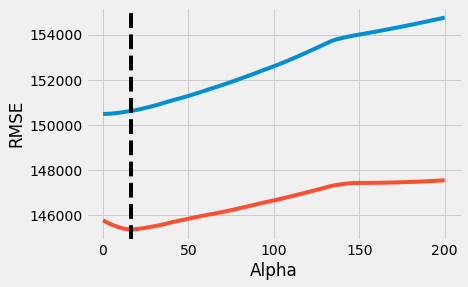

In [22]:
# tr_rmse_lasso = []
# tt_rmse_lasso = []
# alphas_lasso = []

# for alpha in np.linspace(0, 200, num=50):
#     lasso = Lasso(alpha=alpha)
#     lasso.fit(X_tr2, y_tr2)
#     tr_pred = lasso.predict(X_tr2)
#     tr_rmse_lasso.append(np.sqrt(mean_squared_error(y_tr2, tr_pred)))
#     tt_pred = lasso.predict(X_tt2)
#     tt_rmse_lasso.append(np.sqrt(mean_squared_error(y_tt2, tt_pred)))
#     alphas_lasso.append(alpha)

# fig, ax = plt.subplots()
# ax.plot(alphas_lasso, tr_rmse_lasso, label="Train")
# ax.plot(alphas_lasso, tt_rmse_lasso, label="Test")
# ax.set_xlabel("Alpha")
# ax.set_ylabel("RMSE")
# optimal_alpha = alphas_lasso[np.argmin(tt_rmse_lasso)]
# ax.axvline(optimal_alpha, color="black", linestyle="--")
# print(f'Optimal Alpha Value: {int(optimal_alpha)}')
# plt.savefig('images/optimal_lasso.png')

<img src="images/optimal_lasso.png">

In [23]:
lasso = Lasso(alpha=16, normalize=False)
lasso.fit(X_tr2, y_tr2)
y_best_lasso_tr = lasso.predict(X_tr2)
y_best_lasso_tt = lasso.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_best_lasso_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_best_lasso_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_best_lasso_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_best_lasso_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_best_lasso_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_best_lasso_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_best_lasso_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_best_lasso_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_best_lasso_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_best_lasso_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_best_lasso_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_best_lasso_tt)))

Training R^2 Score:  0.839
Training MAE:  89304.42
Training MSE:  2.2686e+10
Training RMSE:  150617.9
Training Bias:  0.0
Training Variance:  1.1760e+11

Testing R^2 Score:  0.8412
Testing MAE:  86111.85
Testing MSE:  2.1129e+10
Testing RMSE:  145357.18
Testing Bias:  4859.58
Testing Variance:  1.1413e+11


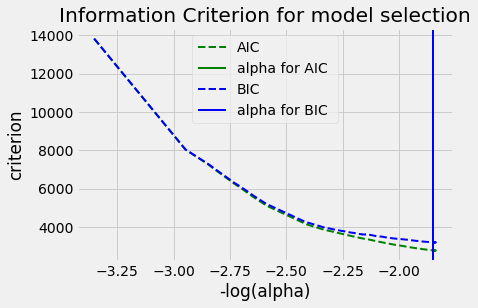

In [28]:
model_bic = LassoLarsIC(criterion="bic")
model_bic.fit(X_tr2, y_tr2)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion="aic")
model_aic.fit(X_tr2, y_tr2)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label=name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2, label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title("Information Criterion for model selection");

In [29]:
aic_lasso = Lasso(alpha=model_aic.alpha_).fit(X_tr2, y_tr2)
aic_tr_pred = aic_lasso.predict(X_tr2)
aic_tt_pred = aic_lasso.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, aic_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, aic_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, aic_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, aic_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, aic_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(aic_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, aic_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, aic_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, aic_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, aic_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, aic_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(aic_tt_pred)))

Training R^2 Score:  0.8365
Training MAE:  90008.23
Training MSE:  2.3042e+10
Training RMSE:  151797.15
Training Bias:  0.0
Training Variance:  1.1572e+11

Testing R^2 Score:  0.8395
Testing MAE:  86894.64
Testing MSE:  2.1362e+10
Testing RMSE:  146157.15
Testing Bias:  5285.32
Testing Variance:  1.1447e+11


In [30]:
bic_lasso = Lasso(alpha=model_bic.alpha_).fit(X_tr2, y_tr2)
bic_tr_pred = bic_lasso.predict(X_tr2)
bic_tt_pred = bic_lasso.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, bic_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, bic_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, bic_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, bic_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, bic_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(bic_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, bic_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, bic_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, bic_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, bic_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, bic_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(bic_tt_pred)))

Training R^2 Score:  0.8365
Training MAE:  90008.23
Training MSE:  2.3042e+10
Training RMSE:  151797.15
Training Bias:  0.0
Training Variance:  1.1572e+11

Testing R^2 Score:  0.8395
Testing MAE:  86894.64
Testing MSE:  2.1362e+10
Testing RMSE:  146157.15
Testing Bias:  5285.32
Testing Variance:  1.1447e+11


## Decision Tree Regressor with GridSearchCV and Pipeline

In [24]:
dtm = DecisionTreeRegressor(random_state=42).fit(X_tr2, y_tr2)
y_tr_pred3 = dtm.predict(X_tr2) 
y_tt_pred3 = dtm.predict(X_tt2)
print('Training R^2 Score: ', round(r2_score(y_tr2, y_tr_pred3), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_tr_pred3), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_tr_pred3)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_tr_pred3)), 2))
print('Training Bias: ', round(bias(y_tr2, y_tr_pred3), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred3)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_tt_pred3), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_tt_pred3), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_tt_pred3)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_tt_pred3)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_tt_pred3), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred3)))

Training R^2 Score:  0.9999
Training MAE:  169.94
Training MSE:  1.4119e+07
Training RMSE:  3757.56
Training Bias:  0.0
Training Variance:  1.4090e+11

Testing R^2 Score:  0.7134
Testing MAE:  106027.11
Testing MSE:  3.8133e+10
Testing RMSE:  195277.84
Testing Bias:  8867.8
Testing Variance:  1.3233e+11


In [25]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=1))
dtm = DecisionTreeRegressor()
param_grid = [{
               'decisiontreeregressor__max_depth': [1, 2, 4, 6, 8],
               'decisiontreeregressor__min_samples_leaf': [1, 5, 10, 20, 50, 100],
               'decisiontreeregressor__max_leaf_nodes': [5, 20, 100],
               'decisiontreeregressor__min_samples_split': [5, 10, 20, 40]
             }]
gs = GridSearchCV(pipe_tree, param_grid=param_grid, cv=10, scoring=rmse_scorer, verbose=1)
gs.fit(X_tr2, y_tr2)
print(f"Training Score: {gs.best_score_}")
print(gs.best_estimator_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Training Score: -177947.23501758592
Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=8, max_leaf_nodes=100,
                                       min_samples_leaf=5, min_samples_split=40,
                                       random_state=1))])


In [31]:
gs_model = gs.best_estimator_
gs_model.fit(X_tr2, y_tr2)
gs_tr_pred = gs_model.predict(X_tr2)
gs_tt_pred = gs_model.predict(X_tt2) 

print('Training R^2 Score: ', round(r2_score(y_tr2, gs_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, gs_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, gs_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, gs_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, gs_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(gs_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, gs_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, gs_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, gs_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, gs_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, gs_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(gs_tt_pred)))

Training R^2 Score:  0.8235
Training MAE:  91573.88
Training MSE:  2.4873e+10
Training RMSE:  157713.0
Training Bias:  -0.0
Training Variance:  1.1604e+11

Testing R^2 Score:  0.7527
Testing MAE:  98818.42
Testing MSE:  3.2907e+10
Testing RMSE:  181402.89
Testing Bias:  8838.99
Testing Variance:  1.1522e+11


## Random Forest Regressor

In [32]:
rf = RandomForestRegressor(n_estimators=100, 
                           max_features="auto", 
                           max_depth=100, 
                           min_samples_leaf=4, 
                           min_samples_split=10, 
                           random_state=1).fit(X_tr2, y_tr2)
rf_tr_pred = rf.predict(X_tr2)
rf_tt_pred = rf.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, rf_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(rf_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_tt_pred)))

Training R^2 Score:  0.9385
Training MAE:  45521.87
Training MSE:  8.6650e+09
Training RMSE:  93086.22
Training Bias:  -81.42
Training Variance:  1.1924e+11

Testing R^2 Score:  0.8717
Testing MAE:  72325.65
Testing MSE:  1.7077e+10
Testing RMSE:  130679.94
Testing Bias:  5685.52
Testing Variance:  1.1244e+11


In [56]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X_tr2.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(20)

,importance
sqft_living,0.575386
lat,0.185811
long,0.070759
sqft_living15,0.040826
sqft_above,0.021481
waterfront_1,0.014275
waterfront_0,0.012121
sqft_lot,0.011179
sqft_lot15,0.010704
age,0.006921


In [ ]:
#instantiate a linear regression object
lm_final = Lasso(alpha=163, normalize=False)
lm_final.fit(X_tr2, y_tr2)

In [ ]:
lm_final.coef_

# Pickle

In [ ]:
pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("scaler.pickle", "wb")
pickle.dump(scaler, pickle_out)
pickle_out.close